In [1]:
def video_cut(video, start_time, end_time, count): # save cut video in the same directory
    ffmpeg_extract_subclip(video, start_time, end_time, targetname="Shoplifting"+str(count)+".mp4")

In [2]:
from moviepy.editor import VideoFileClip, vfx

def speed_up_video(input_video_path):
    output_path = input_video_path.replace('.mp4', '_speed.mp4')  
    video = VideoFileClip(input_video_path)
    speedup_video = video.fx(vfx.speedx, 1.5)  
    speedup_video.write_videofile(output_path, codec='libx264') 

*Получаем кадры*

In [3]:
pwd

'/home/trueuser/Desktop/Project GitHub '

In [4]:
import cv2
import os
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from PIL import Image
def receive_frames(video_path, counter):
    #video_path = 'Shoplifting5.mp4' 
    output_folder = 'Frames'
    
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        frame_name = f'frame_{counter}_{frame_count}.jpg'
        cv2.imwrite(os.path.join(output_folder, frame_name), frame)
    
    cap.release()
    #cv2.destroyAllWindows()
    return

In [5]:
# for i in range(1, 49):
#     video_name = f"Videos/Shoplifting{i}.mp4"
#     receive_frames(video_name, i)

In [6]:
import pandas as pd
df_frames = pd.DataFrame(columns = ['file_name', 'labels'])

In [7]:
import pandas as pd
df_frames = pd.read_csv('metadata.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'metadata.csv'

,file_name,labels
30,frame_1_77.jpg,1
49,frame_10_39.jpg,1
60,frame_10_126.jpg,1
90,frame_1_65.jpg,1
91,frame_4_61.jpg,1
...,...,...
11890,frame_7_334.jpg,1
11907,frame_7_623.jpg,1
11909,frame_9_74.jpg,1
11940,frame_1_60.jpg,1


*Добавляем в датафрейм новые кадры*

In [11]:
import os
image_dir = 'Frames'
image_files = os.listdir(image_dir)
new_rows = []
for image_file in image_files:
        file_name = os.path.basename(image_file)
        if file_name not in df_frames['file_name'].values:
            new_row = {'file_name': file_name, 'labels': 0}
            new_rows.append({'file_name': file_name, 'labels': 0})
df_frames = pd.concat([df_frames, pd.DataFrame(new_rows)], ignore_index=True)

In [14]:
df_frames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11980 entries, 0 to 11979
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  11980 non-null  object
 1   labels     11980 non-null  object
dtypes: object(2)
memory usage: 187.3+ KB


*Проставляем метки на кадры краж*

In [2]:
def set_label(number_video, start_frame, finish_frame):
    for i in range(start_frame, finish_frame + 1):
        df_frames.loc[df_frames['file_name'] == f"frame_{number_video}_{i}.jpg", 'labels'] = 1

In [4]:
df_frames = pd.read_csv('metadata.csv')

NameError: name 'pd' is not defined

0 -- не берет товар
1 -- берет товар

In [47]:
set_label(48, 90, 115)

*Просмотров кадров*

In [181]:
# import os
# from PIL import Image
# import time
# def show_video_frames(number_video):
#     path = 'frames'
#     images = [img for img in os.listdir(path) if img.endswith(".jpg") and f"frame_{number_video}" in img]
#     #images.sort()
    
#     for img in images:
#         image_path = os.path.join(path, img)
#         image = Image.open(image_path)
#         image.show()
#         time.sleep(0.25)
#         image.close()
#     return

<Axes: ylabel='Frequency'>

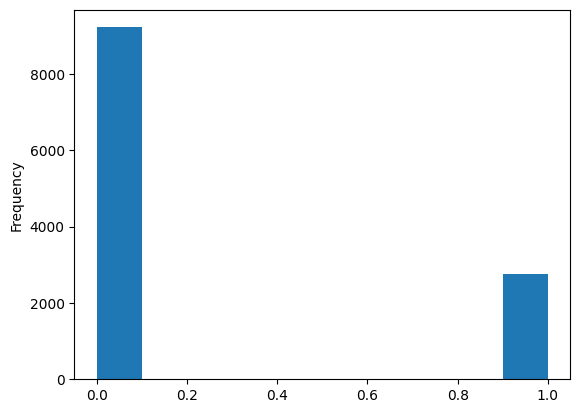

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
df_frames['labels'].plot(kind='hist')

In [18]:
(df_frames['labels'] == 1).sum()

56

In [49]:
df_frames.to_csv('metadata.csv', index=False)